<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter07/ch7_nb8_generate_images_with_gan_models.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 7: Training on Complex and Scarce Datasets</strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">
    Notebook 8:</small><br/>Generating Images with GANs</h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    We just saw how neural networks can be built and trained to understand the distribution of a dataset, in order to generate new samples. <br/><br/>
    In the previous Notebook <a href="./ch7_nb7_generate_images_with_vae_models.ipynb">7-7</a>, we did so with <em>VAEs</em>, teaching one simple model to generate digit image by learning from the MNIST dataset. We will now tackle the same task bit with a different type of generative models: the <strong>Generative Adversarial Networks (<em>GANs</em>)</strong>.
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [1]:
import os
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

os.environ["CUDA_VISIBLE_DEVICES"]= "1"

## Preparing the Dataset

The following code is copy-pasted from the previous notebook. The [MNIST](http://yann.lecun.com/exdb/mnist) dataset[$^1$](#ref) should not have any secret to our readers anymore...

In [2]:
# num_classes = 10
img_rows, img_cols, img_ch = 28, 28, 1
input_shape = (img_rows, img_cols, img_ch)
batch_size = 200
num_epochs = 31

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 127.5 - 1., x_test / 127.5 - 1.

x_train = x_train.reshape(x_train.shape[0], *input_shape).astype(np.float32)
x_test = x_test.reshape(x_test.shape[0], *input_shape).astype(np.float32)

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.apply(
    tf.data.experimental.shuffle_and_repeat(len(x_train), num_epochs, random_seed))
train_dataset = train_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test)
val_dataset = val_dataset.batch(batch_size)


train_steps_per_epoch = math.ceil(x_train.shape[0] / batch_size)
val_steps_per_epoch   = math.ceil(x_test.shape[0] / batch_size)

In [5]:
from plot_utils import plot_image_grid

num_show = 9
val_dataset_samples = val_dataset.take(1)
val_samples = next(val_dataset_samples.__iter__())[:num_show]

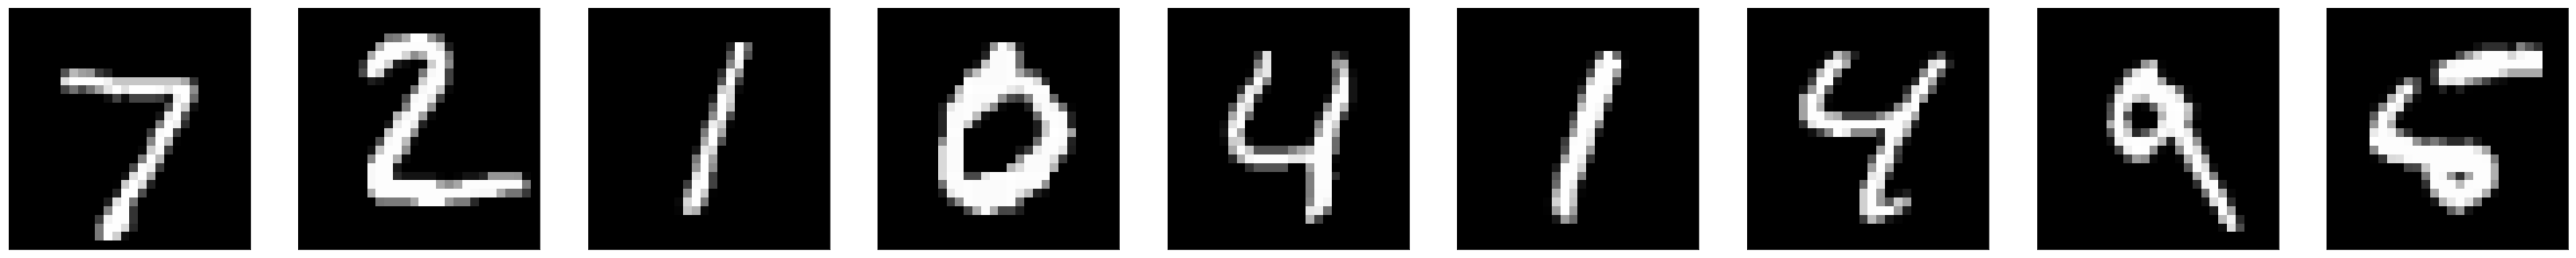

In [24]:
val_samples_imgs = (val_samples.numpy() + 1.) / 2
val_samples_imgs = np.tile(val_samples_imgs, (1, 1, 1, 3))

figure = plot_image_grid([val_samples_imgs], grayscale=True, transpose=True)
figure.show()

## Creating a Generative Adversarial Network

In this section, we will demonstrate how to build a GAN[$^2$](#ref).

### Generator and Discriminator Networks

As presented in Chapter 7, the idea of GANs is to pit a generative network against a discriminative one. The former is taked to generate realistic images, and the latter is trained to distinguish between fake and real images.

For these two networks, we reuse the simple architectures defined in previous notebooks:

In [7]:
# Network hyper-parameters:
kernel_size       = 4
noise_dim         = 2
filters_orig_gen  = 64
layer_depth_gen   = 3
filters_orig_disc = 64
layer_depth_disc  = 3

In [8]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (Input, InputLayer, Lambda, Conv2D, 
                                     BatchNormalization, Flatten, Dense, Reshape, 
                                     Conv2DTranspose, Activation, LeakyReLU, Dropout)

# c.f. DAE architecture in Chapter 6, Notebook 3
def simple_encoder(input_shape, latent_dim=32, 
                   kernel_size=4, filters_orig=32, layer_depth=4,
                   final_activation=None, name='encoder'):
    """
    Build a simple encoder network.
    :param input_shape:      Shape of the input image (H x W x C)
    :param latent_dim:       Size of the latent space
    :param kernel_size:      Kernel size for the convolutions
    :param filters_orig:     Number of filters for the 1st CNN layer (then multiplied by 2 each layer)
    :param layer_depth:      Number of layers composing the encoder/decoder
    :param final_activation: Activation function for the last layer
    :param name:             Model name
    :return:                 Encoder model
    """
    
    layers = []
    layers += [
        # Taking images as inputs:
        InputLayer(input_shape=input_shape)
    ]
    for i in range(layer_depth):
        # Adding conv layers to extract features:
        layers += [
            Conv2D(filters=min(filters_orig * (2 ** i), 512),
                   kernel_size=kernel_size, activation=None, strides=2, 
                   padding='same'),
            BatchNormalization(),
            LeakyReLU(),
            Dropout(0.3)
        ]
    layers += [
        # Flattening feature vectors and outputting result vector:
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(latent_dim, activation=final_activation)
    ]
    
    return Sequential(layers, name=name)
    
def simple_decoder(output_shape, latent_dim=32, 
                   kernel_size=4, filters_orig=32, layer_depth=4,
                   final_activation=None, name='decoder'):
    """
    Build a simple decoder network.
    :param output_shape:     Shape of the output image (H x W x C)
    :param latent_dim:       Size of the latent space
    :param kernel_size:      Kernel size for the convolutions
    :param filters_orig:     Number of filters for the 1st CNN layer (then multiplied by 2 each layer)
    :param layer_depth:      Number of layers composing the encoder/decoder
    :param final_activation: Activation function for the last layer
    :param name:             Model name
    :return:                 Decoder model
    """
    
    # c.f. Chapter 6, Notebook 3
    ResizeToOutputShapeLayer = lambda name: Lambda(
            lambda images: tf.image.resize(images, output_shape[:2]), name=name)
    
    divided_size = np.ceil(np.asarray(output_shape[:2]) / (2 ** layer_depth)).astype(np.int32)
    filters = filters_orig * (2 ** layer_depth)
    
    layers = []
    layers += [
        # Taking codes from the latent space as inputs:
        InputLayer(input_shape=(latent_dim,)),
        # Extending and reshaping into a 2D feature map:
        Dense(units=divided_size[0] * divided_size[1] * filters, activation=None),
        BatchNormalization(),
        Activation('relu'), # LeakyReLU(),
        Reshape(target_shape=(*divided_size, filters)),
        Dropout(0.3)
    ]
    for i in range(layer_depth):
        # Upsampling/convolving to decode into an image:
        layers += [
            Conv2DTranspose(filters=min(filters_orig * (2 ** (layer_depth - i - 1)), 512), 
                            kernel_size=kernel_size, activation=None, strides=2, 
                            padding='same'),
            BatchNormalization(),
            Activation('relu') # LeakyReLU()
        ]
    
    layers += [
        # Making sure to get back the original dimensions:
        ResizeToOutputShapeLayer('resize_to_orig'),
        # Decoding and outputting the image:
        Conv2DTranspose(filters=input_shape[-1], kernel_size=kernel_size, 
                        activation=final_activation,
                        strides=1, padding='same')
    ]
    
    return Sequential(layers, name=name)

We then instantiate our two networks:

In [9]:
# Generator (transforming a noise vector of shape `(laten_dim,)`
# into an image of shape `(img_row, img_col, img_ch)`:
generator = simple_decoder(input_shape, noise_dim, kernel_size,
                           filters_orig_gen, layer_depth_gen, 'tanh', 'generator')
generator.summary()

# Discriminator performing a binary classification, judging if
# images are real or fake (i.e., 2 classes):
discriminator = simple_encoder(input_shape, 2, kernel_size, 
                               filters_orig_disc, layer_depth_disc, None, 'discriminator')
discriminator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              24576     
_________________________________________________________________
batch_normalization_v2 (Batc (None, 8192)              32768     
_________________________________________________________________
activation (Activation)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         2097408   
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 8, 8, 256)         10

## Training and Testing a GAN

Because the two networks should be trained one against the other, we cannot use a classic training loop.
We have to define our own training step, to update the weight of both networks following the operations described in Chapter 7.

***Note:*** While we could use the method `.train_on_batch(...)` of Keras models to train each network over its batch inside our custom training step, we will instead manually define the feed-forwarding and back-propagating, as an excuse to remind ourselves how `tf.GradientTape` works.

In [10]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.SGD()

In [11]:
@tf.function
def gan_train_step(image_batch):
    """
    Perform one training step for the GAN model.
    :param image_batch:     Batch of real training images
    :return:                Loss of the generator, Loss of the discriminator
    """

    batch_size  = tf.shape(image_batch)[0]
    
    real_images = image_batch
    real_labels = tf.ones((batch_size,))
    fake_labels = tf.zeros((batch_size,))
    all_labels  = tf.concat((real_labels, fake_labels), axis=0)
    
    z_noise = tf.random.normal((batch_size, noise_dim))
    with tf.GradientTape() as discriminator_tape, tf.GradientTape() as generator_tape:
        # Generating fake images:
        fake_images = generator(z_noise, training=True)
    
        # Classifying real/fake images:
        pred_labels_on_real = discriminator(real_images, training=True)
        pred_labels_on_fake = discriminator(fake_images, training=True)

        pred_labels_on_all = tf.concat((pred_labels_on_real, pred_labels_on_fake), axis=0)
    
        # Computing the losses:
        discriminator_loss = loss(all_labels, pred_labels_on_all)
        generator_loss = loss(real_labels, pred_labels_on_fake)
        
    
    # Finally, back-propagating the gradients into both networks:
    discriminator_grad = discriminator_tape.gradient(discriminator_loss, 
                                                     discriminator.trainable_variables)
    generator_grad = generator_tape.gradient(generator_loss, 
                                             generator.trainable_variables)
    discriminator_optimizer.apply_gradients(
        zip(discriminator_grad, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(
        zip(generator_grad, generator.trainable_variables))
    
    return generator_loss, discriminator_loss

In [ ]:
"""
Note: In the above function, data is first feed-forwarded into the 2 networks, 
then back-propagation is performed. However, it is common to have instead the discriminator
trained first over the batch (feed-forwarding then back-propagating), and only after to
train the generator. Find below an implementation of such a variant of the GAN training step.
"""

# @tf.function
# def gan_train_step(image_batch, num_iter_for_discriminator=1):
# 
#     batch_size  = tf.shape(image_batch)[0]
#     
#     real_images = image_batch
#     real_labels = tf.ones((batch_size,))
#     fake_labels = tf.zeros((batch_size,))
#     
#     soft_real_labels = real_labels + tf.random.normal((batch_size,), mean=0., stddev=.1)
#     soft_fake_labels = tf.math.abs(
#         fake_labels + tf.random.normal((batch_size,), mean=0., stddev=.1))
#     soft_all_labels  = tf.concat((soft_real_labels, soft_fake_labels), axis=0)
#     
#     # First, we train the discriminator:
#     discriminator_loss_avg = []
#     for i in range(num_iter_for_discriminator):
#         z_noise = tf.random.normal((batch_size, noise_dim))
#         with tf.GradientTape() as discriminator_tape:
#             # Generating fake images:
#             fake_images = generator(z_noise, training=False)
#     
#             # Classifying real/fake images:
#             pred_labels_on_real = discriminator(real_images, training=True)
#             pred_labels_on_fake = discriminator(fake_images, training=True)
# 
#             pred_labels_on_all = tf.concat((pred_labels_on_real, pred_labels_on_fake), axis=0)
# 
#             # Computing the loss:
#             discriminator_loss = loss(soft_all_labels, pred_labels_on_all)
#         
#         # Back-propagating:
#         discriminator_grad = discriminator_tape.gradient(
#             discriminator_loss, discriminator.trainable_variables)
#         discriminator_optimizer.apply_gradients(
#             zip(discriminator_grad, discriminator.trainable_variables))
#         discriminator_loss_avg.append(discriminator_loss)
#         
#     # Keeping average loss value for logs:    
#     discriminator_loss_avg = tf.reduce_mean(tf.stack(discriminator_loss_avg, axis=0))
#         
#     # Then we train the generator:
#     with tf.GradientTape() as generator_tape:
#         z_noise = tf.random.normal((batch_size, noise_dim))
#         
#         # Generating fake images:
#         fake_images = generator(z_noise, training=True)
#         
#         # Classifying if they look real-ish:
#         pred_labels_on_fake = discriminator(fake_images, training=False)
#         
#         # Computing the loss:
#         generator_loss = loss(real_labels, pred_labels_on_fake)
#     
#     # Back-propagating:
#     generator_grad = generator_tape.gradient(
#         generator_loss, generator.trainable_variables)
#     generator_optimizer.apply_gradients(
#         zip(generator_grad, generator.trainable_variables))
#     
#     return generator_loss, discriminator_loss_avg

We also define a validation step, to collect validation metrics:

In [12]:
@tf.function
def gan_val_step(image_batch):

    batch_size  = tf.shape(image_batch)[0]
    
    real_images = image_batch
    real_labels = tf.ones((batch_size,))
    fake_labels = tf.zeros((batch_size,))
    all_labels  = tf.concat((real_labels, fake_labels), axis=0)
    
    z_noise = tf.random.normal((batch_size, noise_dim))
    
    # Generating fake images:
    fake_images = generator(z_noise, training=False)
    
    # Classifying real/fake images:
    pred_labels_on_real = discriminator(real_images, training=False)
    pred_labels_on_fake = discriminator(fake_images, training=False)
    
    pred_labels_on_all = tf.concat((pred_labels_on_real, pred_labels_on_fake), axis=0)
    
    # Computing the losses:
    discriminator_loss = loss(all_labels, pred_labels_on_all)
    generator_loss = loss(real_labels, pred_labels_on_fake)
    
    return generator_loss, discriminator_loss

We also set up some of the usual metrics and callbacks. Since we will use a custom training loop, we will have to call the callbacks manually.

In [19]:
import collections
from keras_custom_callbacks import SimpleLogCallback, TensorBoardImageGridCallback

model_name = 'mnist_gan'
model_dir = os.path.join('models', model_name)

# Callback to postprocess some validation results and display them in Tensorboard:
# Fixed noise vectors to generate images from:
z_noise_samples = tf.random.normal((num_show, noise_dim))

# Function to post-process the results, i.e. to convert noise vectors in images before plotting,
# as down in Notebook 6-1:
def process_images_before_plot(input_z, pred_imgs, target_imgs=None):
    # Transforming noise vectors into plottable images:
    noise_min, noise_max = tf.reduce_min(input_z), tf.reduce_max(input_z)
    input_z = (input_z - noise_min) / (noise_max - noise_min)
    input_z_imgs = np.tile(np.expand_dims(np.expand_dims(input_z, 1), -1), 
                           (1, 2, 1, 3))
    # Normalizing generated images from [-1, 1] to [0, 1] and tiling channels:
    pred_imgs = (pred_imgs + 1.) / 2
    pred_imgs = np.tile(pred_imgs, (1, 1, 1, 3))

    return input_z_imgs, pred_imgs, target_imgs

callback_tb_grid = TensorBoardImageGridCallback(
    log_dir=model_dir, preprocess_fn=process_images_before_plot,
    input_images=z_noise_samples, target_images=None, 
    grayscale=True, transpose=True,
    tag=model_name + '_results', figsize=(15, 15))

# Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1):
metrics_to_print = collections.OrderedDict([("g_loss", "g_loss"), 
                                            ("d_loss", "d_loss"),
                                            ("val_g_loss", "val_g_loss"), 
                                            ("val_d_loss", "val_d_loss")])
callback_simple_log = SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=2)


callback_tb_grid.set_model(generator)
custom_callbacks = [callback_simple_log, callback_tb_grid]

<Figure size 4500x4500 with 0 Axes>

Finally, we define our custom training loop. We define a first function for an epoch loop, and a second to wrap the whole training together, with validation and calls to the callback functions after each epoch:

In [20]:
import functools

def loop_for_epoch(step_fn, dataset_iter, train_steps_per_epoch,
                   generator_loss_accumulator, discriminator_loss_accumulator):
    for i in range(train_steps_per_epoch):
        batch = next(dataset_iter)
        generator_loss, discriminator_loss = step_fn(batch)
        generator_loss_accumulator.update_state(generator_loss)
        discriminator_loss_accumulator.update_state(discriminator_loss)
    
    # End of training epoch:
    accumulated_generator_loss = generator_loss_accumulator.result()
    accumulated_discriminator_loss = discriminator_loss_accumulator.result()
    tf.summary.scalar('gen_loss', accumulated_generator_loss, 
                      step=generator_optimizer.iterations)
    tf.summary.scalar('disc_loss', accumulated_discriminator_loss, 
                      step=discriminator_optimizer.iterations)
    generator_loss_accumulator.reset_states()
    discriminator_loss_accumulator.reset_states()
    return accumulated_generator_loss.numpy(), accumulated_discriminator_loss.numpy()


def train(train_dataset, epochs, train_steps_per_epoch,
          val_dataset=None, val_steps_per_epoch=None,
          summary_dir='./summaries', callbacks=[]):  
    
    train_summary_writer = tf.summary.create_file_writer(
        os.path.join(summary_dir, 'train'))
    if val_dataset is not None:
        val_summary_writer = tf.summary.create_file_writer(
            os.path.join(summary_dir, 'val'))
    avg_generator_loss = tf.keras.metrics.Mean(name='avg_gen_loss', dtype=tf.float32)
    avg_discriminator_loss = tf.keras.metrics.Mean(name='avg_disc_loss', dtype=tf.float32)
    
    for cb in custom_callbacks:
        cb.on_train_begin()
        
    train_dataset_iter = train_dataset.__iter__()
    for epoch in range(epochs):
        with train_summary_writer.as_default():
            g_train_loss, d_train_loss = loop_for_epoch(
                gan_train_step, train_dataset_iter, train_steps_per_epoch,
                avg_generator_loss, avg_discriminator_loss)

        if val_dataset is not None:
            val_dataset_iter = val_dataset.__iter__()
            with val_summary_writer.as_default():
                g_val_loss, d_val_loss = loop_for_epoch(
                    gan_val_step, val_dataset_iter, val_steps_per_epoch,
                    avg_generator_loss, avg_discriminator_loss)
        else: 
            g_val_loss, d_val_loss = np.nan, np.nan
        
        logs = {'g_loss': g_train_loss, 'd_loss': d_train_loss,
                'val_g_loss': g_val_loss, 'val_d_loss': d_val_loss}
        for cb in custom_callbacks:
            cb.on_epoch_end(epoch, logs)
                    
    for cb in custom_callbacks:
        cb.on_train_end()

In [21]:
train(train_dataset=train_dataset, epochs=num_epochs, 
      train_steps_per_epoch=train_steps_per_epoch,
      val_dataset=val_dataset, val_steps_per_epoch=val_steps_per_epoch,
      summary_dir=os.path.join(model_dir, 'summaries'), callbacks=custom_callbacks)

Training: start.
Epoch  1/17: g_loss = 0.851; d_loss = 0.690; val_g_loss = 0.455; val_d_loss = 0.734
Epoch  3/17: g_loss = 0.723; d_loss = 0.769; val_g_loss = 0.403; val_d_loss = 0.771
Epoch  5/17: g_loss = 0.801; d_loss = 0.689; val_g_loss = 0.491; val_d_loss = 0.723
Epoch  7/17: g_loss = 0.819; d_loss = 0.675; val_g_loss = 0.538; val_d_loss = 0.687
Epoch  9/17: g_loss = 0.774; d_loss = 0.701; val_g_loss = 0.980; val_d_loss = 0.484
Epoch 11/17: g_loss = 0.734; d_loss = 0.722; val_g_loss = 0.469; val_d_loss = 0.747
Epoch 13/17: g_loss = 0.757; d_loss = 0.696; val_g_loss = 0.537; val_d_loss = 0.696
Epoch 15/17: g_loss = 0.732; d_loss = 0.712; val_g_loss = 0.546; val_d_loss = 0.718
Training: end.


Like the encode in VAEs, the discriminator is usually discarded once the model trained, to keep only the generative network.

As done in Notebook [7-7](ch7_nb7_generate_images_with_vae_models.ipynb) for our VAE, we now display some images generated from random noise vectors, as well as images generated from a grid of vectors:

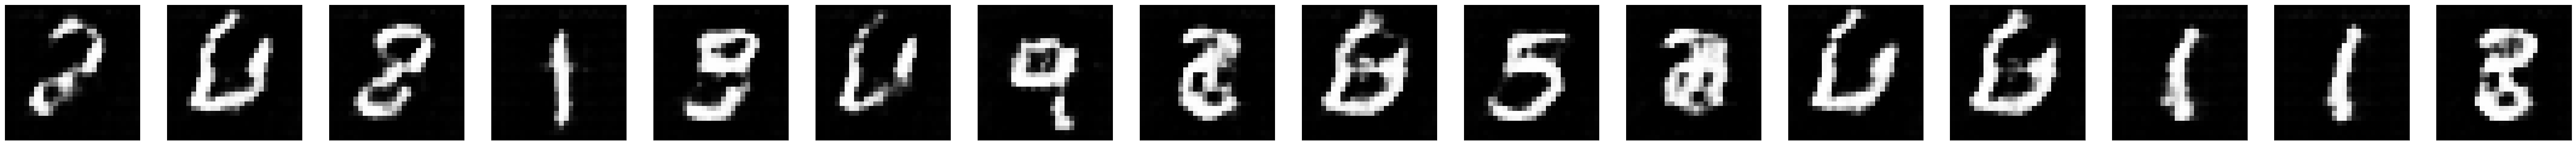

In [22]:
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, noise_dim])
images = generator(random_vector_for_generation)

images = (images + 1.) / 2
images = np.tile(images, (1, 1, 1, 3))

figure = plot_image_grid([images], grayscale=True, transpose=True)
figure.show()

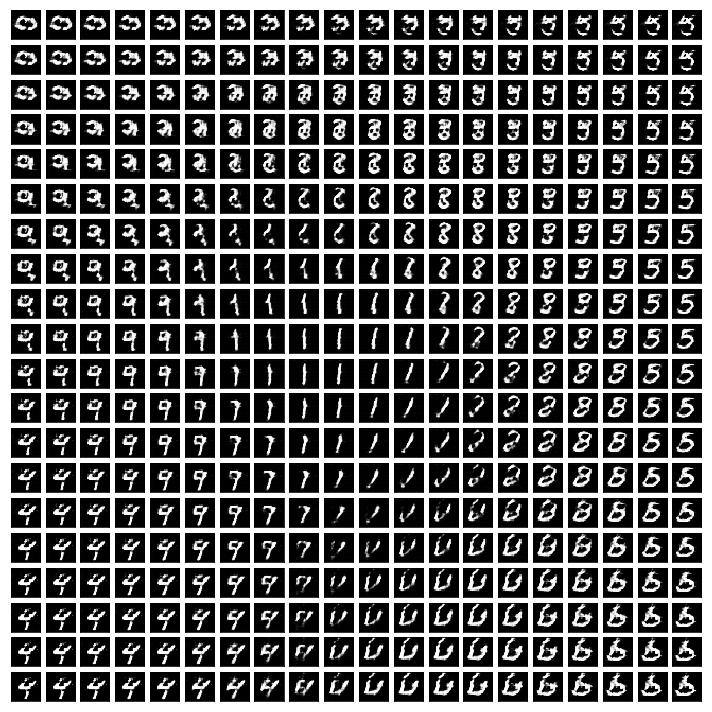

In [23]:
# We built a 2D latent space, so let us explore it.

dim1_num, dim2_num = 20, 20
dim1_grid = np.linspace(-1.5, 1.5, dim1_num)
dim2_grid = np.linspace(-1.5, 1.5, dim2_num)

z_samples = []
for dim1_val in dim1_grid:
    for dim2_val in dim2_grid:
        z_sample = np.array([dim1_val, dim2_val])
        z_samples.append(z_sample)

z_samples = np.stack(z_samples, axis=0)
images = generator.predict(z_samples) 
images = (images + 1.) / 2
images = np.tile(images, (1, 1, 1, 3))
images = np.reshape(images, (dim1_num, dim2_num, img_rows, img_cols, 3))
   
figure = plot_image_grid(images, 
                         figure=plt.figure(figsize=(10, 10)),
                         grayscale=True)
figure.show()

## Conclusion

As we can observe in the results above, even though the generator itself was never fed with actual images, it learnt how to generate _digit-like_ images (our architectures and losses were too simple here to expect high-quality results). Note that GANs are infamously hard to train (we recommend having a look at the training hack listed by Soumith Chintala et al.: https://github.com/soumith/ganhacks).

Even though, GANs are popular and powerful tools, and many advanced models have been proposed to generate detailed images or to transform existing images (as GANs can not only be conditioned on noise vector, but also any kind of data, images included).

<a id="ref"></a>
#### References

1. 1. LeCun, Y., Cortes, C., Burges, C., 2010. MNIST handwritten digit database. AT&T Labs [Online]. Available: http://yann.lecun.com/exdb/mnist 2, 18.
2. Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A. and Bengio, Y., 2014. Generative adversarial nets. In Advances in neural information processing systems (pp. 2672-2680).